## Whale Sound Classification

In this notebook we will discuss ways to classify signals using annotated data.

Objectives:
* train a machine learning classifier with the scikit-learn package
* learn how to evaluate machine learning models



<img src="img/whale_classification.png" width=200/>

In the kaggle competition we had the privilage to have annotated data. So let's use those labels. We are in fact trying to solve a classification problem: we want to build a classifier which correctly identifies whale calls.

### Data Loading
---

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing multiple visualization libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import mlab
import pylab as pl
import seaborn

In [3]:
# importing libraries to manipulate the data files
import os
from glob import glob

In [4]:
# import numpy
import numpy as np

In [5]:
# loading the data
X = np.load('X.npy')
y = np.load('y.npy')
print(y)

[0 0 0 ... 0 0 0]


### Data Splitting
---

We will split the dataset in two parts: a training set and a testing set.

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=2018)


### Model Fitting
---

[//]:![text](https://gist.githubusercontent.com/amueller/4642976/raw/e48eff2df7790583f1f3212095d24639738a1b4a/drop_shadows.svg?sanitize=true)

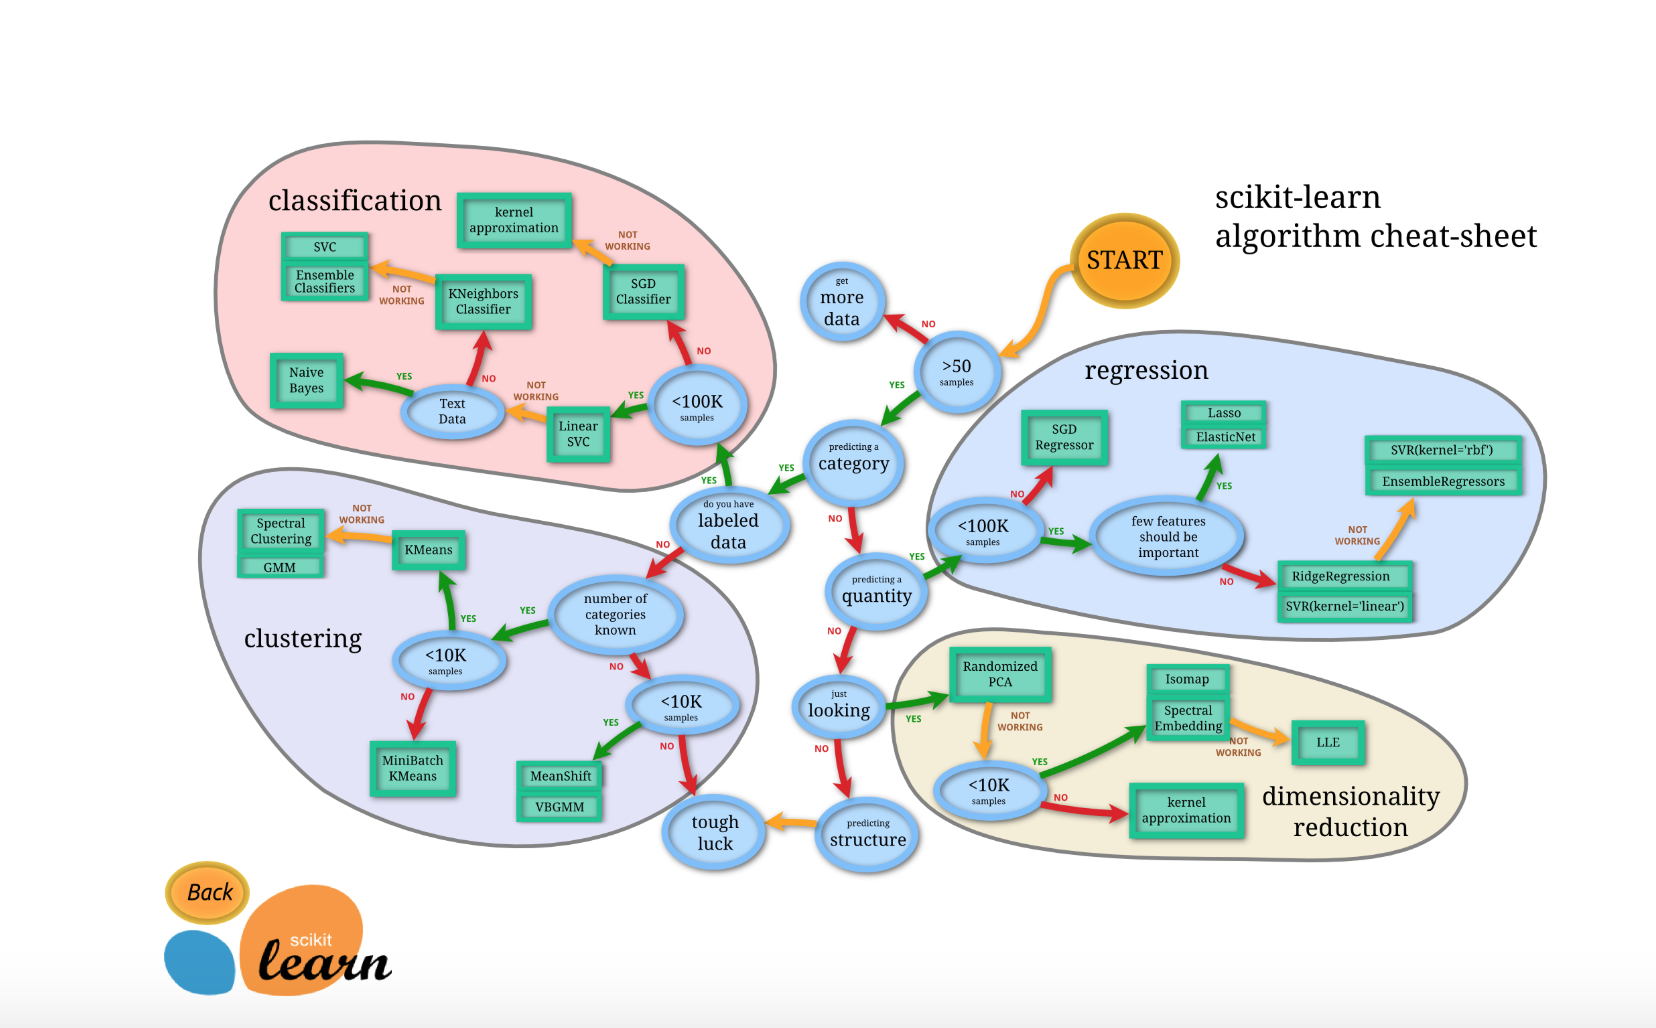

In [8]:
from  IPython.display import Image
Image("img/MLmap.png" )

Source: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html 

`scikit learn` has many built-in classification algorithms. A couple of methods that tend to perform really well in practice are:
* Support Vector Classifier ([SVC](http://scikit-learn.org/stable/modules/svm.html)) - a linear classifier
* [Random Forests](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) - a nonlinear classifier (ensemble method)

In [9]:
from sklearn.ensemble import RandomForestClassifier

/Users/valentina/anaconda/envs/data_mining_test/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [10]:
print(y_train)
clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

[0 0 0 ... 0 0 1]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

### Evaluation and Model Selection
---

**Accuracy**

Ok, we fitted a classifier, but how should we evaluate performance? First let's look at the accuracy on the train dataset: it better be good!!!

In [11]:
# prediction on the training dataset
train_accuracy = 1 - np.sum(np.abs(clf.predict(X_train) - y_train))/len(y_train)
print('Accuracy on the train dataset is '+ str(train_accuracy))

Accuracy on the train dataset is 0.9341666666666667


But that does not matter, what we want to know is how the method performs on the test dataset, whose labels we have not seen in training.

In [12]:
# prediction on the testing dataset
test_accuracy = 1 - np.sum(np.abs(clf.predict(X_test)-y_test))/len(y_test)
print('Accuracy on the test dataset is '+ str(test_accuracy))

Accuracy on the test dataset is 0.844


Ok, it is lower, as expected, but still decent.

**Receiver Operating Characteristic (ROC) Curves**

Note: the Random Forest Classifier is a probalistic algorithm and in fact can output a score for the chance of belonging to a class.

In [13]:
# predicting class
y_pred = clf.predict(X_test)

# predicting score for each class 
y_score = clf.predict_proba(X_test)[:,1]
print(y_score)

[0.33406848 0.25336438 0.00721702 ... 0.00330567 0.30727013 0.00922169]


Normally, we can set a decision threshold which determines the class:
    
`y_score>0.5`: right whale upcall

`y_score<0.5`: no right whale upcall
    
But we can adjust this threshold to improve the performance. 

To study this performance we can use the [Receiver Operating Characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) and the Area Under the Curve (ROC AUC).

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
roc_auc = roc_auc_score(y_test, y_score)
fpr, tpr, _ = roc_curve(y_test, y_score)


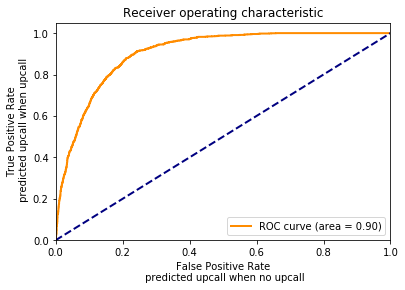

In [15]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate\n predicted upcall when no upcall')
plt.ylabel('True Positive Rate\n predicted upcall when upcall')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

If we set the threshold to 0, we will identify all whale upcalls, but also all the no upcalls will be identified as upcalls.

If we set the threshold to 1, we will miss all the whale upcalls, but won't have wrongly identified no upcalls.

The area under the curve (AUC) gives us a measure for the performance under different thresholds. It is good when close to 1. But is this enough?

Question: what will be the accuracy if we always claim there is no whale call?

Hint: what is the percentage of snippets with whale calls?

In [16]:
1 - y_test.sum()/len(y_test)

0.7695

So we can achieve pretty decent accuracy with a crappy classifier, which never detects 0 of all upcalls.

We definity need to look at other metics.

**Confusion Matrix**

It is useful to look at all types of errors the algorithm makes. For, that we compute the confusion matrix.

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.91 0.09]
 [0.38 0.62]]


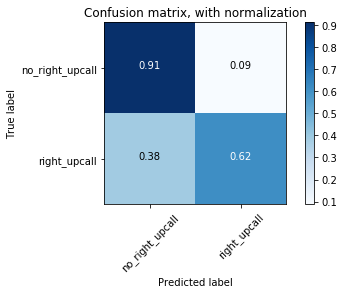

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
class_names = ['no_right_upcall','right_upcall']
plot_confusion_matrix(cnf_matrix, classes=class_names,normalize=True,
                      title='Confusion matrix, with normalization')

**Precision and Recall**

Precision: $\frac{\textrm{correctly predicted upcalls}}{\textrm{predicted upcalls}}$

In [20]:
# calculate precision with formula
predicted_upcalls = (y_pred==1)

precision = sum(y_test[predicted_upcalls])/sum(predicted_upcalls)
print(precision)

0.6780876494023904


In [21]:
# calculate precision with scikit-learn function
from sklearn.metrics import precision_score

precision_score(y_test, y_pred)

0.6780876494023904

In [22]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_pred, y_test)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.48


Text(0.5,1,'2-class Precision-Recall curve: AP=0.48')

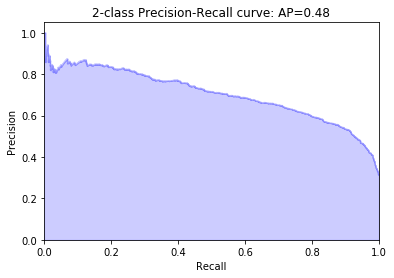

In [23]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, y_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

[F1 score](https://en.wikipedia.org/wiki/F1_score) is a measure which combines both precision and recall.

$\textrm{F1} = 2 \frac{\textrm{precision x recall}}{\text{precision+recall}}$

In [24]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

0.645185746777862

How can we improve:


* perform [cross validation](http://scikit-learn.org/stable/modules/cross_validation.html)

* try other classifiers: [gradient boosting](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html), [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) and compare their ROC/PR curves

* account for time shifting

* apply some normalization??

* apply dimensionality reduction first and then classify

* ???


### References:
* https://github.com/jaimeps/whale-sound-classification

* https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Scikit_Learn_Cheat_Sheet_Python.pdf